# Step 8: Prototyping.

In the previous section we selected our base model, but did not finely tune it. We achieved a an accuracy of 99.1%, validation accuracy of 91.6%, and our F1 score was 0.915. In this section let's see if we can tune hyper parameters to improve on this result.

In [1]:
%load_ext tensorboard

In [2]:
import numpy as np
import matplotlib.pyplot as plt 
import tensorflow as tf
import tensorflow_hub as hub

from tensorflow import keras
from tensorflow.keras import layers
from tensorboard.plugins.hparams import api as hp

## 8.1: Loading the data

In [3]:
import pathlib
import os.path

data_dir =  pathlib.Path(os.path.abspath("images/Flowers5/"))
data_dir

WindowsPath('E:/school/UCSD-ML-Capstone/images/Flowers5')

In [4]:
batch_size = 32
epochs=25
img_height = 192
img_width = 192

In [5]:
train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(data_dir, validation_split=0.2, subset="both", seed=123,
                                                               image_size=(img_height, img_width), batch_size=batch_size)

Found 1857 files belonging to 5 classes.
Using 1486 files for training.
Using 371 files for validation.


In [6]:
class_names = train_ds.class_names
num_classes = len(class_names)
num_classes
print(class_names)

['Calceolaria', 'Daffodil', 'Freesia', 'Hibiscus', 'Iris']


In [7]:
model_url = 'https://tfhub.dev/google/bit/s-r101x1/1'
base_model = hub.KerasLayer(model_url)

## 8.2: Hyper parameter tuning.

Here we test different hyper parameters and log their F1 score. This was based on this [codelab](https://www.tensorflow.org/tensorboard/hyperparameter_tuning_with_hparams).

In [10]:
HP_NUM_UNITS = hp.HParam('num_units', hp.Discrete([16, 32]))
HP_DROPOUT = hp.HParam('dropout', hp.RealInterval(0.2, 0.4))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam' ])) #, 'sgd'])) -- we already tested sgd, adam was better.

METRIC_F1_SCORE = 'f1_score'

with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
    hp.hparams_config(
        hparams=[HP_NUM_UNITS, HP_DROPOUT, HP_OPTIMIZER],
        metrics=[hp.Metric(METRIC_F1_SCORE, display_name='F1 Score')],
    )

In [11]:
from sklearn.metrics import f1_score as sk_f1

# Define our own function since we are working with batch datasets.
def f1_score(model):
    y_pred = []  # store predicted labels
    y_true = []  # store true labels

    # We iterate over the dataset to get the true label and input at the same time.
    # Otherwise we will unintentionally shuffle the dataset.
    for image_batch, label_batch in val_ds:
        y_true.append(label_batch)
        preds = model.predict(image_batch, verbose=0)
        y_pred.append(np.argmax(preds, axis = - 1))

    # convert the true and predicted labels into tensors
    correct_labels = tf.concat([item for item in y_true], axis = 0)
    predicted_labels = tf.concat([item for item in y_pred], axis = 0)
    
    return sk_f1(correct_labels, predicted_labels, average=None)

In [12]:
def train_test_model(hparams):
    model = tf.keras.Sequential([
        layers.Rescaling(1./255),
        base_model,
        layers.Flatten(),
        layers.Dense(hparams[HP_NUM_UNITS], activation='relu'),
        layers.Dropout(hparams[HP_DROPOUT]),
        layers.Dense(num_classes),
    ])
    model.compile(
        optimizer=hparams[HP_OPTIMIZER],
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy'],
    )

    model.fit(train_ds, validation_data=val_ds, epochs=epochs, verbose=1)
    f1 = f1_score(model)
    print("f1:", f1)
    return np.mean(f1)

In [13]:
def run(run_dir, hparams):
    with tf.summary.create_file_writer(run_dir).as_default():
        hp.hparams(hparams)  # record the values used in this trial
        f1 = train_test_model(hparams)
        tf.summary.scalar(METRIC_F1_SCORE, f1, step=1)

In [14]:
session_num = 100

In [15]:
for num_units in HP_NUM_UNITS.domain.values:
    for dropout_rate in np.linspace(
        HP_DROPOUT.domain.min_value,
        HP_DROPOUT.domain.max_value,
        num=6,
    ):
        for optimizer in HP_OPTIMIZER.domain.values:
            hparams = {
                HP_NUM_UNITS: num_units,
                HP_DROPOUT: dropout_rate,
                HP_OPTIMIZER: optimizer,
            }
            run_name = "run-%d" % session_num
            print('--- Starting trial: %s' % run_name)
            print({h.name: hparams[h] for h in hparams})
            run('logs/hparam_tuning/' + run_name, hparams)
            session_num += 1

--- Starting trial: run-100
{'num_units': 16, 'dropout': 0.2, 'optimizer': 'adam'}
Epoch 1/25
47/47 [==============================] - 45s 336ms/step - loss: 0.9937 - accuracy: 0.6083 - val_loss: 0.5581 - val_accuracy: 0.8275
Epoch 2/25
47/47 [==============================] - 12s 251ms/step - loss: 0.5346 - accuracy: 0.8001 - val_loss: 0.4249 - val_accuracy: 0.8679
Epoch 3/25
47/47 [==============================] - 12s 255ms/step - loss: 0.4202 - accuracy: 0.8493 - val_loss: 0.3440 - val_accuracy: 0.8922
Epoch 4/25
47/47 [==============================] - 12s 258ms/step - loss: 0.3485 - accuracy: 0.8668 - val_loss: 0.3048 - val_accuracy: 0.9057
Epoch 5/25
47/47 [==============================] - 12s 261ms/step - loss: 0.2977 - accuracy: 0.8930 - val_loss: 0.2812 - val_accuracy: 0.9111
Epoch 6/25
47/47 [==============================] - 12s 263ms/step - loss: 0.2652 - accuracy: 0.9092 - val_loss: 0.2629 - val_accuracy: 0.9030
Epoch 7/25
47/47 [==============================] - 13s 266

## 8.3 Results

In [18]:
%tensorboard --logdir logs/hparam_tuning --host localhost

Reusing TensorBoard on port 6006 (pid 26980), started 1:28:35 ago. (Use '!kill 26980' to kill it.)

We can use the Tensorboard to see how the parameters affected our outcome. Below is a screenshot so it can be easily viewed in GitHub.

![Tensorboard](step8-tensorboard.png)

From the board we can tell that 'adam' was better than 'sgd' in general. The dropout rate seems to have a big impact too, likely by reducing bias in our model. Let's see if we can narrow down on the dropout rate for the 'adam' optimizer. To do so I updated the code above and re-ran it to get some more results. The results are logged to file so the previous runs won't be forgotten.

![Tensorboard 2](step8-tensorboard-2.png)

It looks like the best hyper parameters were: 
 * num_units = 16
 * dropout = 0.24
 * optimizer = adam
 
 We got an F1 score of 95, which is pretty good.
 
 

## 8.4: Final model

Let's build the model with the best score from our hyper parameter test and graph its performance.

In [16]:
model = tf.keras.Sequential([
    layers.Rescaling(1./255),
    base_model,
    layers.Flatten(),
    layers.Dense(16, activation='relu'),
    layers.Dropout(0.25),
    layers.Dense(num_classes),
])
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, verbose=1)
f1 = f1_score(model)

Epoch 1/25
47/47 [==============================] - 21s 307ms/step - loss: 1.1673 - accuracy: 0.5390 - val_loss: 0.6967 - val_accuracy: 0.7817
Epoch 2/25
47/47 [==============================] - 12s 249ms/step - loss: 0.7253 - accuracy: 0.7147 - val_loss: 0.5449 - val_accuracy: 0.8275
Epoch 3/25
47/47 [==============================] - 12s 249ms/step - loss: 0.6018 - accuracy: 0.7645 - val_loss: 0.4181 - val_accuracy: 0.8841
Epoch 4/25
47/47 [==============================] - 12s 249ms/step - loss: 0.4870 - accuracy: 0.8022 - val_loss: 0.3516 - val_accuracy: 0.8949
Epoch 5/25
47/47 [==============================] - 12s 249ms/step - loss: 0.4154 - accuracy: 0.8479 - val_loss: 0.3518 - val_accuracy: 0.8787
Epoch 6/25
47/47 [==============================] - 12s 249ms/step - loss: 0.3929 - accuracy: 0.8614 - val_loss: 0.3097 - val_accuracy: 0.9003
Epoch 7/25
47/47 [==============================] - 12s 249ms/step - loss: 0.3450 - accuracy: 0.8742 - val_loss: 0.2764 - val_accuracy: 0.9164

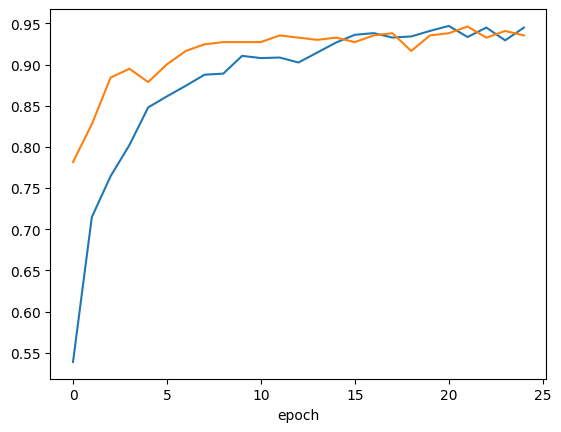

In [17]:
plt.plot(history.history['accuracy'], label = 'accuracy')
plt.plot(history.history['val_accuracy'], label = 'validation accuracy')
plt.xlabel('epoch')
plt.show()